# DSD-2019 Project (MNIST)
---
# Simple python inference

In [1]:
from layers_mnist import *
from bitop_mnist import *
from setup_mnist import *
from scale_uart import *
from matplotlib import pyplot as plt
import time
import numpy as np
%matplotlib inline

## Download the MNIST dataset         

http://yann.lecun.com/exdb/mnist/

---

In [2]:
download_dataset()

Download the MNIST dataset from http://yann.lecun.com/exdb/mnist/
Finish download the MNIST dataset.


### Unzip the gz file into ubyte

In [3]:
unzip_mnist("./dataset_mnist/train-images-idx3-ubyte.gz")
unzip_mnist("./dataset_mnist/train-images-idx1-ubyte.gz")
unzip_mnist("./dataset_mnist/t10k-images-idx3-ubyte.gz")
unzip_mnist("./dataset_mnist/t10k-images-idx1-ubyte.gz")

## Load the MNIST dataset
---

In [4]:
# TRAIN SET
X_train, y_train = load_mnist("./dataset_mnist/train-images-idx3-ubyte", "./dataset_mnist/train-images-idx1-ubyte")
# TEST SET
X_test, y_test = load_mnist("./dataset_mnist/t10k-images-idx3-ubyte", "./dataset_mnist/t10k-images-idx1-ubyte")
# TEST SET ORIGIN
X_test_origin, _ = load_mnist("./dataset_mnist/t10k-images-idx3-ubyte", "./dataset_mnist/t10k-images-idx1-ubyte")

### Show example MNIST Image

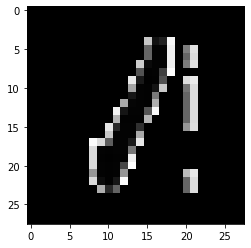

Label: 1


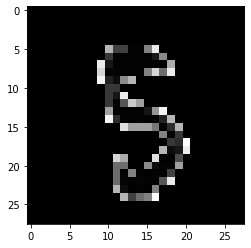

Label: 5


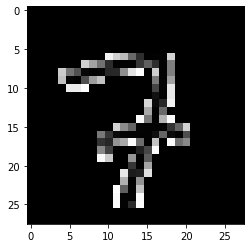

Label: 7


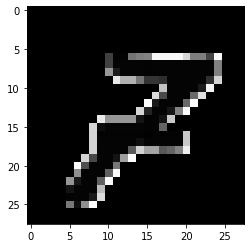

Label: 7


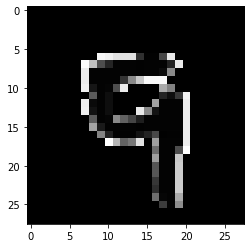

Label: 9


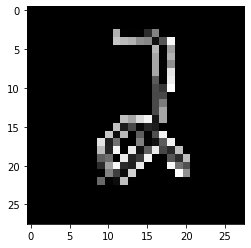

Label: 2


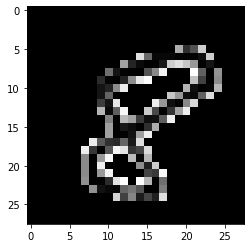

Label: 8


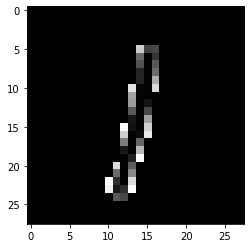

Label: 1


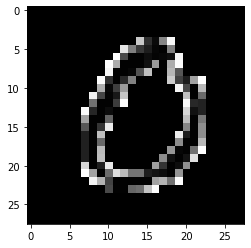

Label: 0


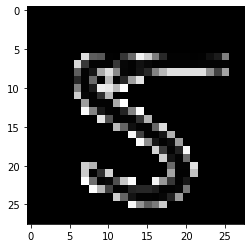

Label: 5


In [5]:
for i in range(10):
    key = np.random.randint(10000)
    gen_image(X_test[key]).show()
    print("Label: %d" %(y_test[key]))

## Preprocess the dataset (normalize)  

It will be **not included** in out PROJECT IMPLEMENATION.

---

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [7]:
mean = np.mean(X_train)
std = np.std(X_train)
print("mean:\t%.4f" %(mean))
print("std:\t%.4f" %(std))

mean:	0.1307
std:	0.3081


In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 28, 28))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 28, 28))
X_train[:, :, :, :] = (X_train[:, :, :, :] - mean) / std
X_test[:, :, :, :] = (X_test[:, :, :, :] - mean) / std

## Train  
---
It is already done by TAs.  
So just load the network parameters!

### Simulation data for our 8-bit MAC unit

In [9]:
X_test_ = np.load("./mnist_dataset_quan/images_1000.npy")

## Load network parameter
---

In [10]:
# Load network param
conv1_w = np.load("./mnist_network_param/mnist_conv1_weight.npy") 
conv1_b = np.load("./mnist_network_param/mnist_conv1_bias.npy")
conv2_w = np.load("./mnist_network_param/mnist_conv2_weight.npy")
conv2_b = np.load("./mnist_network_param/mnist_conv2_bias.npy")
fc1_w = np.load("./mnist_network_param/mnist_fc1_weight.npy")
fc1_b = np.load("./mnist_network_param/mnist_fc1_bias.npy")
fc2_w = np.load("./mnist_network_param/mnist_fc2_weight.npy")
fc2_b = np.load("./mnist_network_param/mnist_fc2_bias.npy")

In [11]:
# 8-bit quantization network param
conv1_w_ = np.load("./mnist_network_quan_param/mnist_conv1_weight_quan.npy")
conv1_b_ = np.load("./mnist_network_quan_param/mnist_conv1_bias_quan.npy")
conv2_w_ = np.load("./mnist_network_quan_param/mnist_conv2_weight_quan.npy")
conv2_b_ = np.load("./mnist_network_quan_param/mnist_conv2_bias_quan.npy")
fc1_w_ = np.load("./mnist_network_quan_param/mnist_fc1_weight_quan.npy")
fc1_b_ = np.load("./mnist_network_quan_param/mnist_fc1_bias_quan.npy")
fc2_w_ = np.load("./mnist_network_quan_param/mnist_fc2_weight_quan.npy")
fc2_b_ = np.load("./mnist_network_quan_param/mnist_fc2_bias_quan.npy")

## Test for accuracy  
---

In [12]:
conv_param = {'stride': 1, 'pad': 1}
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

In [13]:
def inference(data):
    # CONV1 with MAXPOOL
    conv1_out = conv(data, conv1_w, conv1_b, conv_param)
    relu1_out = relu(conv1_out)
    pool1_out = maxpool(relu1_out, pool_param)
    
    # CONV2 with MAXPOOL
    conv2_out = conv(pool1_out, conv2_w, conv2_b, conv_param)
    relu2_out = relu(conv2_out)
    pool2_out = maxpool(relu2_out, pool_param)
    
    # Flatten for FC's input
    flat = np.reshape(pool2_out, (1568,))
    
    # Fully-Connected 1
    fc1_out = fully_connected(flat, fc1_w, fc1_b)
    relu3_out = relu(fc1_out)
    
    # Fully-Connected 2
    fc2_out = fully_connected(relu3_out, fc2_w, fc2_b)
    # !!! EXCLUSION OF RELU ON LAST LAYER !!!
    return fc2_out

In [14]:
def inference_quan(data):
    # CONV1 with MAXPOOL
    conv1_out = conv(data, conv1_w_, conv1_b_, conv_param)
    relu1_out = relu(conv1_out)
    pool1_out = maxpool(relu1_out, pool_param)
    
    # EACH OUTPUT MUST BE TRANSLATED INTO 8-BIT FORM
    pool1_out_ = to_8bit_fixed(pool1_out)
    
    # CONV2 with MAXPOOL
    conv2_out = conv(pool1_out_, conv2_w_, conv2_b_, conv_param)
    relu2_out = relu(conv2_out)
    pool2_out = maxpool(relu2_out, pool_param)
    
    # EACH OUTPUT MUST BE TRANSLATED INTO 8-BIT FORM
    pool2_out_ = to_8bit_fixed(pool2_out)
    
    # Flatten for FC's input
    flat = np.reshape(pool2_out_, (1568,))
    
    # Fully-Connected 1
    fc1_out = fully_connected(flat, fc1_w_, fc1_b_)
    relu3_out = relu(fc1_out)
    
    # EACH OUTPUT MUST BE TRANSLATED INTO 8-BIT FORM
    relu3_out_ = to_8bit_fixed(relu3_out)
    
    # Fully-Connected 2
    fc2_out = fully_connected(relu3_out_, fc2_w_, fc2_b_)
    # !!! EXCLUSION OF RELU ON LAST LAYER !!!
    # CAN SKIP THE QUNATIZATION STEP B.C WE ALLOW 16-BIT OUTCOME ON LAST
    return fc2_out

In [15]:
def check_accuracy(data):
    num_img = data.shape[0]
    pred_label = list()
    scores = list()
    for idx in range(num_img):
        score = inference(data[idx].reshape((1, 1, 28, 28)))
        scores.append(score)
        print("Progress: {:05.2f}%".format(100*idx/(num_img-1)), end="\r", flush=True)
        pred_label.append(np.argmax(score, axis=0))
    return scores, pred_label

In [16]:
def check_accuracy_quan(data):
    num_img = data.shape[0]
    pred_label = list()
    scores = list()
    for idx in range(num_img):
        score = inference_quan(data[idx].reshape((1, 1, 28, 28)))
        scores.append(score)
        print("Progress: {:05.2f}%".format(100*idx/(num_img-1)), end="\r", flush=True)
        pred_label.append(np.argmax(score, axis=0))
    return scores, pred_label

## Do inference and Check the accuracy
---

### JUST MASKED DATA range 1000

In [ ]:
start = time.time()
scores_mask, pred_mask = check_accuracy(X_test[range(1000)])
print("Total time: {:.2f} sec".format(time.time() - start))

In [18]:
start = time.time()
scores_mask_quan, pred_mask_quan = check_accuracy_quan(X_test_[range(1000)])
print("Total time: {:.2f} sec".format(time.time() - start))

Total time: 231.58 sec


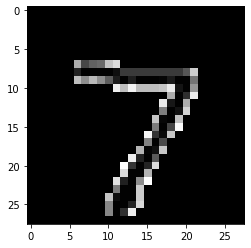

Label: 7	Predict: 7


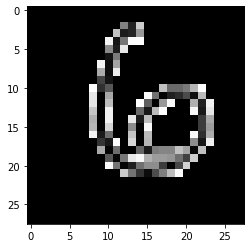

Label: 6	Predict: 6


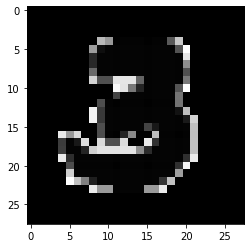

Label: 3	Predict: 3


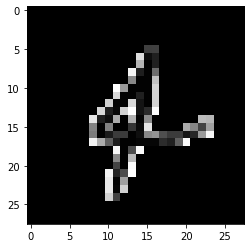

Label: 4	Predict: 4


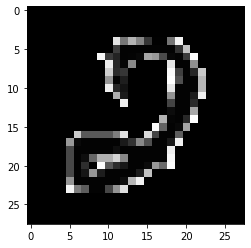

Label: 2	Predict: 2


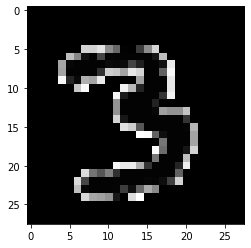

Label: 3	Predict: 3


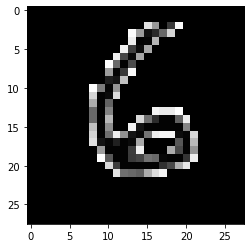

Label: 6	Predict: 6


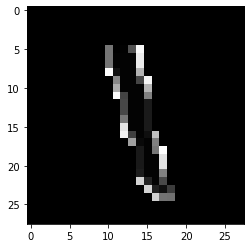

Label: 1	Predict: 1


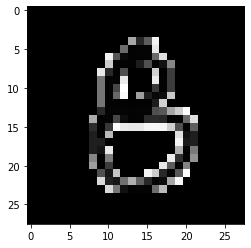

Label: 8	Predict: 8


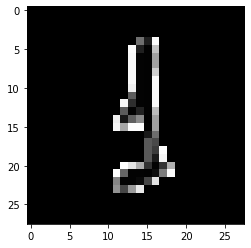

Label: 1	Predict: 1


In [19]:
acc = 0
nac = 0

for idx in range(1000):
    if y_test[idx] == pred_mask[idx]:
        acc += 1
    else:
        nac += 1
    if idx % 100 == 0:
        gen_image(X_test_origin[idx]).show()
        print("Label: %d\tPredict: %d" %(y_test[idx], pred_mask[idx]))
    print("Test accuracy: {:05.2f}%".format(100*(acc/(acc + nac))), end="\r", flush=True)

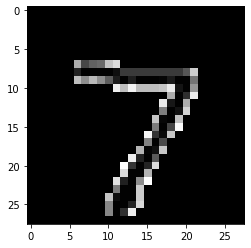

Label: 7	Predict: 7


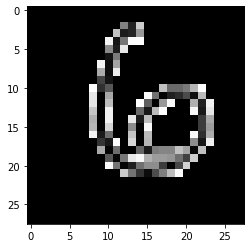

Label: 6	Predict: 6


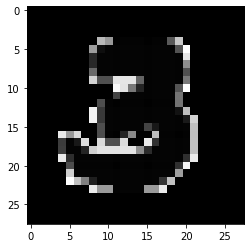

Label: 3	Predict: 3


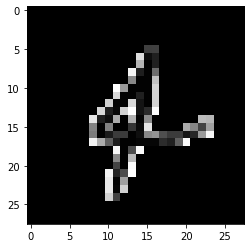

Label: 4	Predict: 4


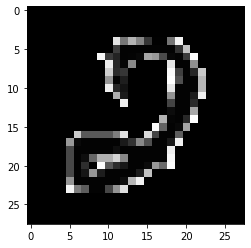

Label: 2	Predict: 2


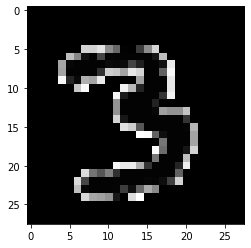

Label: 3	Predict: 3


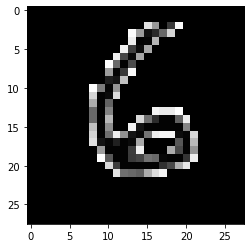

Label: 6	Predict: 6


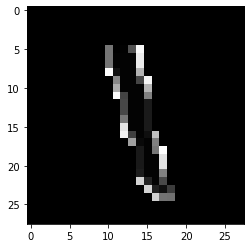

Label: 1	Predict: 1


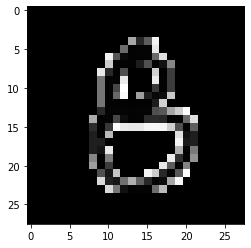

Label: 8	Predict: 8


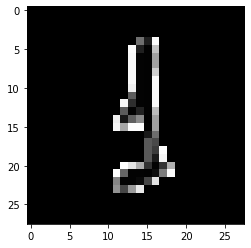

Label: 1	Predict: 1


In [20]:
acc = 0
nac = 0

for idx in range(1000):
    if y_test[idx] == pred_mask_quan[idx]:
        acc += 1
    else:
        nac += 1
    if idx % 100 == 0:
        gen_image(X_test_origin[idx]).show()
        print("Label: %d\tPredict: %d" %(y_test[idx], pred_mask_quan[idx]))
    print("Test accuracy: {:05.2f}%".format(100*(acc/(acc + nac))), end="\r", flush=True)